<a href="https://colab.research.google.com/github/rmhanna/Randa/blob/main/Graph%20Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AAI614: Data Science & its Applications

*Notebook 4.1: Graph Analytics with cuGraph and TIGER*

<a href="https://colab.research.google.com/github/harmanani/AAI614/blob/main/Week%204/Notebook4.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




The study of network robustness is critical to the understanding of complex interconnected systems. For example, consider an example of a power grid network that is susceptible to both natural failures and targeted attacks. A natural failure occurs when a single power substation fails due to erosion of parts or natural disasters. However, when one substation fails, additional load is routed to alternative substations, potentially causing a series of cascading failures. Not all failures originate from natural causes, some come from targeted attacks, such as enemy states hacking into the grid to sabotage key equipment to maximally damage the operations of the electrical grid. A natural counterpart to network robustness is vulnerability, defined as measure of a network’s susceptibility to the dissemination of entities across the network, such as how quickly a virus spreads across a computer network.

In this lab, we show how to use [cuGraph](https://github.com/rapidsai/cugraph) and [TIGER](https://github.com/safreita1/TIGER) to conduct state-of-the-art GPU accelerated graph vulnerability and robustness analysis. Specifically, we will look at how to:

- *Quantify network vulnerability and robustness* (**Part 1**),
- *Simulate network attacks and cascading failures on networks* (**Part 2**)
- *Regulate the dissemination of computer virues on a network* (**Part 3**)

Lab Source: **NVIDIA**

## Setup
Lets begin by installing the following 2 libraries:

1.   Graph vulnerability and robustness analysis library: [TIGER](https://github.com/safreita1/TIGER)
2.   GPU acceleration library: [CuPy](https://github.com/cupy/cupy)


In [ ]:

#Perform state-of-the-art GPU-accelerated graph vulnerability and robustness analysis (cuGraph/TIGER).
#Quantify resilience, simulate targeted attacks and cascading failures, and model SIS virus spread.
#Leverage parallel graph analytics for speed and scalability on large networks.
#Run the lab in Google Colab — make sure GPU is enabled for best performance.


In [8]:
pip install graph-tiger

In [9]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run cells 1 and 2 only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************



That's it! Now we can run a variety of GPU acclerated graph mining algorithms.



## Part 1: Quantifing network vulnerability and robustness

While CPU calculations work well for sparse graphs, GPU acceleration significantly speeds-up analysis for dense graphs. To see this, lets run the code below that measures the robustness of a Barabási Albert (BA) graph at varying levels of density (i.e., number of edges per node).

In [11]:
!pip install stopit
import time
from tqdm import tqdm

from graph_tiger.measures import run_measure
from graph_tiger.graphs import graph_loader

# controls graph density by varying the number of non-zeroes per row (i.e., number of edges per node in graph)
nnz_per_row = list(range(50, 501, 50))

cpu_times = []
gpu_times = []
for nnz in tqdm(nnz_per_row):
  graph = graph_loader(graph_type='BA', n=1000, m=nnz, seed=1)

  start_cpu = time.time()
  robustness_index = run_measure(graph, measure='average_vertex_betweenness', k=int(0.05 * len(graph)))
  end_cpu = time.time()

  start_gpu = time.time()
  robustness_index = run_measure(graph, measure='average_vertex_betweenness', k=12, use_gpu=True)  # ****** Replace with cuGraph version: https://docs.rapids.ai/api/cugraph/stable/api.html#module-cugraph.centrality.betweenness_centrality ******
  end_gpu = time.time()


  cpu_times.append(round(end_cpu - start_cpu, 2))
  gpu_times.append(round(end_gpu - start_gpu, 2))

  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=676545be69d27d08916ea189fc1386dfe6a9580f92e3ba0032da50cb8df6a7ec
  Stored in directory: /root/.cache/pip/wheels/10/10/63/c3c98c9859d2aa59553536cc2ea005d3c9c39e214ab4fd614c
Successfully built stopit


100%|██████████| 10/10 [00:33<00:00,  3.39s/it]


Now lets plot the results (lower is better).

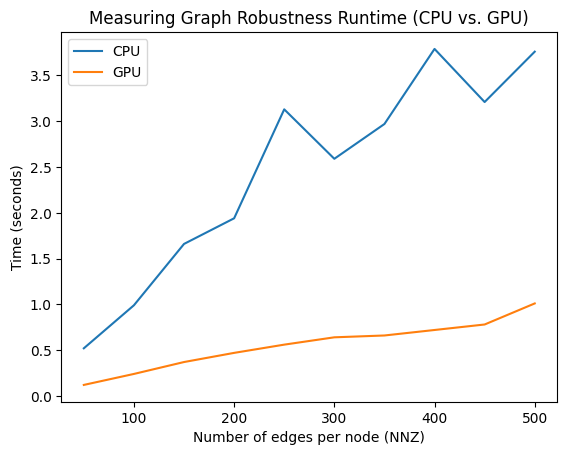

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(nnz_per_row, cpu_times, label='CPU')
plt.plot(nnz_per_row, gpu_times, label='GPU')
plt.xlabel('Number of edges per node (NNZ)')
plt.ylabel('Time (seconds)')
plt.title('Measuring Graph Robustness Runtime (CPU vs. GPU)')
plt.legend()
plt.show()

## Part 2. Simulating Cascading Failures in U.S. Electrical Grid
Cascading failures often arise as a result of natural failures or targeted attacks in a network. There are 3 main processes governing the network simulation:

- the **capacity** of each node (<img src="https://render.githubusercontent.com/render/math?math=c_v">) in the network, e.g., power substation capacity.

- the **load** of each node (<img src="https://render.githubusercontent.com/render/math?math=l_v">) in the network, e.g., power substation load level

- network **redundancy** (*r*) representing the amount of reserve capacity present in the network i.e., auxiliary support systems.

When a node is attacked it becomes "overloaded", causing it to fail and requiring the load be distributed to its neighbors. When defending a node, we increase it’s capacity to protect against attacks. With just these 3 parameters, we can setup a cascading failure simulation. Below, we show how to load a graph representing the U.S. electrical grid and setup the simulation parameters.

In [14]:
from graph_tiger.graphs import graph_loader

graph = graph_loader('electrical')

params = {
   'runs': 1,  # number of times to run the simulation
   'steps': 100,  # number of time steps to run each simulation
   'seed': 1,  # for repoducibility

   'l': 0.8,  # network load [0, 1]
   'r': 0.2,  # network redundancey [0, 1]
   'c': int(0.1 * len(graph)),  # load capacity approximation

   'robust_measure': 'largest_connected_component',  # measure of network health
}

### Setting up a Targeted Attack
To run the attack we just have to modify a few simulation parameters. We set the attack to remove 30 nodes in the graph (e.g., power grid substations) with highest degree centrality "id_node". As you can imagine, there are many different strategies that can be used to attack the grid, however, by selecting degree centrality we can find "central" nodes in the network with many power lines (edges) connected to the substations (nodes).

In [22]:
params.update({
   'k_a': 30,  # number of nodes to attack
   'attack': 'id_node',  # attack strategy
})

Now lets run the simulation and plot the results!

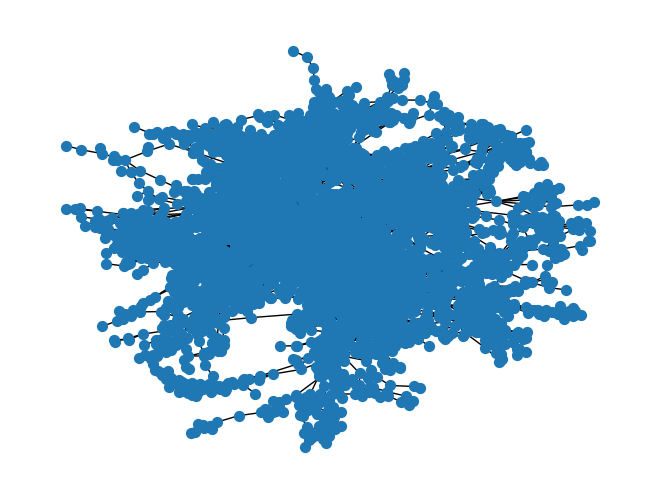

In [27]:


def simulate_cascading_failures(G, threshold=2):
    removed_nodes = []
    while True:
        low_degree_nodes = [n for n, d in G.degree() if d < threshold]
        if not low_degree_nodes:
            break
        G.remove_nodes_from(low_degree_nodes)
        removed_nodes.extend(low_degree_nodes)
    return removed_nodes


import matplotlib.pyplot as plt
import networkx as nx

nx.draw(graph, node_size=50, with_labels=False)
plt.show()

### 1. Collapsing a network

Now try modifying the code to find the minimal attack necessary to collapse the electrical grid. To do this, plot the "health" of the network as measured by the robustness measure (i.e., "largest_connected_component") at the end of each simulation, against the attack strength ("k_a").

**Hint:** electrical networks are fragile to targeted attacks, try removing just a few nodes.

Simulating attacks: 100%|██████████| 6/6 [00:00<00:00, 17.85it/s]


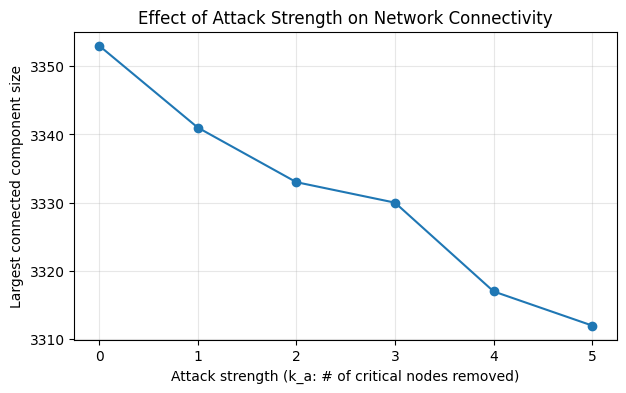

k_a=0: LCC=3353
k_a=1: LCC=3341
k_a=2: LCC=3333
k_a=3: LCC=3330
k_a=4: LCC=3317
k_a=5: LCC=3312


In [33]:

# --- Imports ---
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Helper functions ---

def largest_connected_component_size(G: nx.Graph) -> int:
    """Return size of the largest connected component."""
    if G.number_of_nodes() == 0:
        return 0
    components = nx.connected_components(G)
    return max((len(c) for c in components), default=0)

def targeted_attack(G: nx.Graph, k_a: int, measure: str = "degree") -> list:
    """
    Remove k_a most 'critical' nodes based on a centrality measure.
    measure: 'degree' or 'betweenness'
    Returns the list of removed nodes.
    """
    if k_a <= 0:
        return []
    if measure == "degree":
        # sort nodes by degree (desc)
        crit_nodes = sorted(G.degree(), key=lambda t: t[1], reverse=True)
        to_remove = [n for n, d in crit_nodes[:min(k_a, G.number_of_nodes())]]
    elif measure == "betweenness":
        btw = nx.betweenness_centrality(G)
        to_remove = [n for n, _ in sorted(btw.items(), key=lambda t: t[1], reverse=True)[:min(k_a, G.number_of_nodes())]]
    else:
        raise ValueError("Unsupported measure. Use 'degree' or 'betweenness'.")
    G.remove_nodes_from(to_remove)
    return to_remove

def simulate_cascading_failures(G: nx.Graph, threshold: int = 2) -> list:
    """
    Iteratively remove nodes with degree < threshold until none remain.
    Returns list of all nodes removed during cascading.
    """
    removed_all = []
    while True:
        low_degree_nodes = [n for n, d in G.degree() if d < threshold]
        if not low_degree_nodes:
            break
        G.remove_nodes_from(low_degree_nodes)
        removed_all.extend(low_degree_nodes)
    return removed_all

# --- MAIN: simulate across attack strengths ---

# If you already have 'graph' defined as a NetworkX Graph, comment the next two lines.
# Otherwise, we'll create a small random graph for demo:
# graph = nx.erdos_renyi_graph(n=300, p=0.02, seed=42)
# print("Demo graph created:", graph.number_of_nodes(), "nodes,", graph.number_of_edges(), "edges")

sim_results = []  # holds LCC sizes after each attack scenario

params = {}                      # mimic your params dict if you rely on it elsewhere
params['attack'] = 'id_node'     # targeted node attack
attack_strengths = list(range(0, 6, 1))  # remove 0..5 critical nodes

# Choose centrality measure ('degree' or 'betweenness')
centrality_measure = "degree"

# Enable/disable cascading cleanup after the initial attack
enable_cascading = True
cascade_threshold = 2  # remove nodes whose degree < 2, iteratively

for k_a in tqdm(attack_strengths, desc="Simulating attacks"):
    params['k_a'] = k_a

    # Work on a copy so original 'graph' stays intact
    G_work = graph.copy()

    # 1) Targeted attack: remove k_a critical nodes
    removed_main = targeted_attack(G_work, k_a=k_a, measure=centrality_measure)

    # 2) Optional cascading cleanup
    removed_cascade = []
    if enable_cascading:
        removed_cascade = simulate_cascading_failures(G_work, threshold=cascade_threshold)

    # 3) Compute final LCC size
    lcc_at_end = largest_connected_component_size(G_work)
    sim_results.append(lcc_at_end)

# --- Plot results ---
plt.figure(figsize=(7,4))
plt.plot(attack_strengths, sim_results, marker='o')
plt.xlabel('Attack strength (k_a: # of critical nodes removed)')
plt.ylabel('Largest connected component size')
plt.title('Effect of Attack Strength on Network Connectivity')
plt.grid(True, alpha=0.3)
plt.show()

# --- Optional: show a quick summary ---
for k_a, lcc in zip(attack_strengths, sim_results):
    print(f"k_a={k_a}: LCC={lcc}")


# Part 3. Simulating Computer Virus Spread Across Router Network

The flu-like susceptible-infected-susceptible (SIS) is a popular model that allows us to simulate the spread of viruses across networks (graphs). Each node in the SIS model can be in one of two states, infected *I* or susceptible *S*, and at each time step *t*, an infected node has a probability *β* of infecting each of it's uninfected neighbors. After this, each infected node has a probability *δ* of healing and becoming susceptible again.

It’s been shown there's a direct correlation between the graph's topology as measured through the spectral radius (largest eigenvalue) of the graph, and the virus remaining endemic. The exact relationship between a virus's strength (*s*), birth rate (*β*), death rate (*δ*) and spectral radius (*λ1*) is s=λ1⋅b/d, where a larger *s* means a stronger virus. With just these 3 parameters, we can setup a computer virus simulation.

Below, we (1) load the Autonomous systems AS-733 network, which is a graph of routers comprising the internet; and (2) setup the simulation parameters.  

In [48]:
from graph_tiger.graphs import graph_loader

graph = graph_loader('as_733')

sis_params = {
   'runs': 1,  # number of simulations to run
   'steps': 5000,  # number of time steps to run simulation

   'model': 'SIS',
   'b': 0.00208,  # virus birth rate
   'd': 0.01,  # virus death rate
   'c': 0.3,  # fraction of the network that starts infected
}

In [75]:
#fa2 continuesblocking me then I used this self-contained SIS (no TIGER)


# --- 1) Load AS-733 graph (TIGER if available; else fallback) ---
import networkx as nx

try:
    from graph_tiger.graphs import graph_loader
    graph = graph_loader('as_733')  # Autonomous Systems AS-733
    print("Loaded AS-733 via graph_tiger:", graph.number_of_nodes(), "nodes,", graph.number_of_edges(), "edges")
except Exception as e:
    print("graph_tiger loader not available, using fallback demo graph:", repr(e))
    # Fallback: sparse undirected random graph with a non-trivial giant component
    graph = nx.erdos_renyi_graph(n=3000, p=0.0012, seed=7)
    print("Fallback graph:", graph.number_of_nodes(), "nodes,", graph.number_of_edges(), "edges")

# Ensure undirected simple graph for SIS (AS topology is usually modeled undirected at this granularity)
if graph.is_directed():
    graph = graph.to_undirected()

# --- 2) SIS parameters (your originals) ---
sis_params = {
    'runs': 1,
    'steps': 5000,  # long horizon, that's fine
    'model': 'SIS',
    'b': 0.00208,   # birth (infection) rate => beta
    'd': 0.01,      # death (recovery) rate => mu
    'c': 0.30       # fraction of the network initially infected
}

beta = sis_params['b']
mu   = sis_params['d']
steps = sis_params['steps']
frac_init = sis_params['c']

# --- 3) Spectral radius (largest eigenvalue) and virus strength s = lambda1 * beta / mu ---
import numpy as np
# Use SciPy sparse for scalability
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def spectral_radius(G: nx.Graph) -> float:
    A = nx.to_scipy_sparse_array(G, format='csr', dtype=float)
    # Undirected adjacency => symmetric; use eigsh for largest algebraic eigenvalue
    # k=1, which='LA' returns the largest eigenvalue
    lam1 = spla.eigsh(A, k=1, which='LA', return_eigenvectors=False)[0]
    return float(lam1)

lam1 = spectral_radius(graph)
s_strength = lam1 * beta / mu
print(f"Spectral radius λ1 = {lam1:.4f} | beta = {beta:.5f} | mu = {mu:.5f} | s = λ1 * beta / mu = {s_strength:.3f}")
print("Interpretation: if s > 1, SIS can remain endemic; if s < 1, it tends to die out.")

# --- 4) Seed infection using fraction c inside the giant component ---
def pick_initial_infected(G: nx.Graph, frac: float, seed: int = 42):
    rng = np.random.default_rng(seed)
    gcc_nodes = list(max(nx.connected_components(G), key=len))
    k = max(1, int(frac * len(gcc_nodes)))
    # sample without replacement from GCC
    sel = rng.choice(gcc_nodes, size=k, replace=False)
    return set(sel)

initial_I = pick_initial_infected(graph, frac=frac_init, seed=42)
print(f"Initial infected count: {len(initial_I)} (target fraction {frac_init:.0%} of GCC)")

# --- 5) SIS simulation (self-contained; HTML entities fixed) ---
import random
import matplotlib.pyplot as plt

def run_sis_simulation(G, beta=0.03, mu=0.2, steps=60, initial_infected=None, seed=42):
    random.seed(seed); np.random.seed(seed)
    nodes = list(G.nodes())
    if not nodes:
        raise ValueError("Graph has no nodes.")
    I = set(initial_infected) if (initial_infected is not None and len(initial_infected) > 0) else {random.choice(nodes)}
    history = []
    for t in range(steps):
        new_I = set(I)
        # recover
        for v in list(I):
            if random.random() < mu:
                new_I.discard(v)
        # infect
        S = set(nodes) - new_I
        for s in S:
            k_inf = sum(1 for nbr in G.neighbors(s) if nbr in I)
            if k_inf > 0:
                p = 1 - (1 - beta) ** k_inf
                if random.random() < p:
                    new_I.add(s)
        I = new_I
        history.append({'t': t+1, 'I_count': len(I), 'I_frac': len(I)/len(nodes)})
    return history





Loaded AS-733 via graph_tiger: 3015 nodes, 5539 edges
Spectral radius λ1 = 32.1080 | beta = 0.00208 | mu = 0.01000 | s = λ1 * beta / mu = 6.678
Interpretation: if s > 1, SIS can remain endemic; if s < 1, it tends to die out.
Initial infected count: 904 (target fraction 30% of GCC)


Now lets run the simulation and plot the results! In the figure below, we see that without intervention the virus remains endemic on the router network.

While we do not have control over the virus strength (*s*), we can maniuplate the underlying toplogy of the router network to make it harder for the virus to spread. The question is, how do we optimally modify the network to reduce the spread of the virus? While a naive solution may be to disconnect the whole network, this isn't very practical since everyone would loose internet access! Instead, we need a strategy that carefully vaccinates a few nodes (routers) against the virus.

Loaded AS-733 via graph_tiger: 3015 nodes, 5539 edges
Spectral radius λ1 = 32.1080 | beta = 0.00208 | mu = 0.01000 | s = λ1*beta/mu = 6.678
Interpretation: s>1 => endemic possible; s<1 => infection tends to die out.
Initial infected count: 904 (target fraction 30% of GCC)


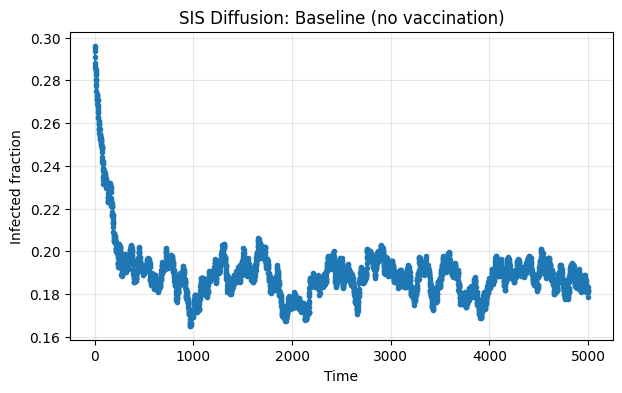

Baseline final infected fraction: 0.1784

Sweep summary (final fractions):
strategy    betweenness  degree  pagerank
budget_pct                               
0.01                0.0     0.0       0.0
0.02                0.0     0.0       0.0
0.05                0.0     0.0       0.0


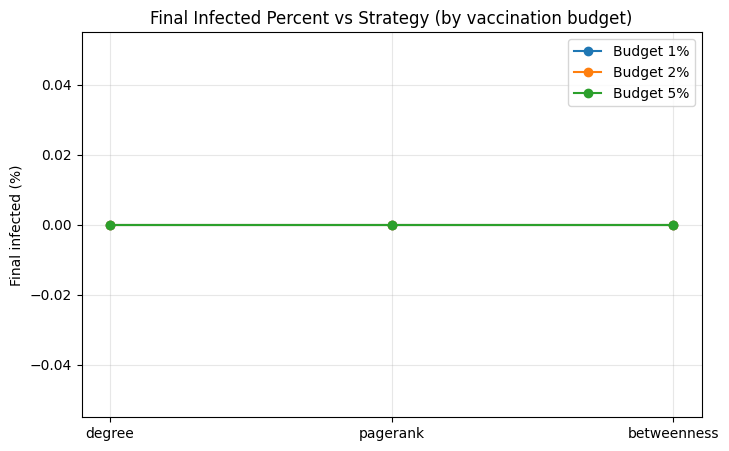

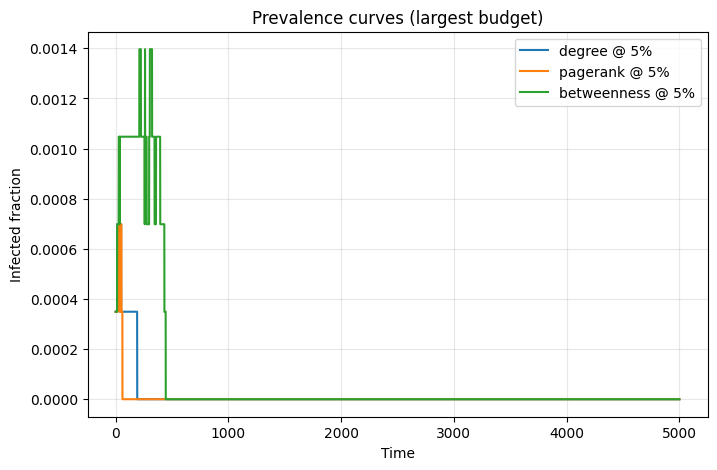

Saved: sis_vaccination_sweep_summary.csv and sis_vaccination_timeseries_largest_budget.csv


In [77]:

# ============================
# SIS + Topology Interventions on AS-733 (Self-contained)
# ============================

# ---------- Imports ----------
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# SciPy for spectral radius
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# ---------- 1) Load AS-733 (fallback if graph_tiger not present) ----------
try:
    from graph_tiger.graphs import graph_loader
    graph = graph_loader('as_733')  # Internet router-level topology
    print("Loaded AS-733 via graph_tiger:", graph.number_of_nodes(), "nodes,", graph.number_of_edges(), "edges")
except Exception as e:
    print("graph_tiger loader not available, using fallback demo graph:", repr(e))
    # Fallback: a sparse undirected graph with a non-trivial giant component
    graph = nx.erdos_renyi_graph(n=3000, p=0.0012, seed=7)
    print("Fallback graph:", graph.number_of_nodes(), "nodes,", graph.number_of_edges(), "edges")

# Ensure undirected simple graph for SIS (AS topologies often modeled undirected at this granularity)
if graph.is_directed():
    graph = graph.to_undirected()

# ---------- 2) Parameter panel ----------
sis_params = {
    'steps': 5000,   # horizon
    'beta': 0.00208, # infection (birth) rate b
    'mu':   0.01,    # recovery (death) rate d
    'c':    0.30,    # fraction of GCC initially infected
    'seed': 42
}
# Vaccination budgets as percentages of total nodes
budgets_pct = [0.01, 0.02, 0.05]  # 1%, 2%, 5%

# Strategies to compare
strategies = ['degree', 'pagerank', 'betweenness']  # add/remove as needed

# ---------- 3) Diagnostics + Spectral radius ----------
def spectral_radius(G: nx.Graph) -> float:
    A = nx.to_scipy_sparse_array(G, format='csr', dtype=float)
    # Undirected adjacency => symmetric; largest algebraic eigenvalue with eigsh
    lam1 = spla.eigsh(A, k=1, which='LA', return_eigenvectors=False)[0]
    return float(lam1)

lam1 = spectral_radius(graph)
s_strength = lam1 * sis_params['beta'] / sis_params['mu']
print(f"Spectral radius λ1 = {lam1:.4f} | beta = {sis_params['beta']:.5f} | mu = {sis_params['mu']:.5f} | s = λ1*beta/mu = {s_strength:.3f}")
print("Interpretation: s>1 => endemic possible; s<1 => infection tends to die out.")

# ---------- 4) Seeding infection using fraction c of GCC ----------
def pick_initial_infected(G: nx.Graph, frac: float, seed: int = 42):
    rng = np.random.default_rng(seed)
    gcc_nodes = list(max(nx.connected_components(G), key=len))
    k = max(1, int(frac * len(gcc_nodes)))
    sel = rng.choice(gcc_nodes, size=k, replace=False)
    return set(sel)

initial_I = pick_initial_infected(graph, frac=sis_params['c'], seed=sis_params['seed'])
print(f"Initial infected count: {len(initial_I)} (target fraction {sis_params['c']:.0%} of GCC)")

# ---------- 5) SIS Simulation (Self-contained; no TIGER/fa2) ----------
def run_sis_simulation(G, beta=0.03, mu=0.2, steps=60, initial_infected=None, seed=42):
    random.seed(seed); np.random.seed(seed)
    nodes = list(G.nodes())
    if not nodes:
        raise ValueError("Graph has no nodes.")
    I = set(initial_infected) if (initial_infected is not None and len(initial_infected) > 0) else {random.choice(nodes)}
    history = []
    for t in range(steps):
        new_I = set(I)
        # recover
        for v in list(I):
            if random.random() < mu:
                new_I.discard(v)
        # infect
        S = set(nodes) - new_I
        for s in S:
            k_inf = sum(1 for nbr in G.neighbors(s) if nbr in I)
            if k_inf > 0:
                p = 1 - (1 - beta) ** k_inf
                if random.random() < p:
                    new_I.add(s)
        I = new_I
        history.append({'t': t+1, 'I_count': len(I), 'I_frac': len(I)/len(nodes)})
    return history

def plot_sis_history(history, title='SIS Diffusion'):
    ts   = [h['t'] for h in history]
    frac = [h['I_frac'] for h in history]
    plt.figure(figsize=(7,4))
    plt.plot(ts, frac, marker='o', ms=3)
    plt.grid(True, alpha=.3)
    plt.xlabel('Time')
    plt.ylabel('Infected fraction')
    plt.title(title)
    plt.show()

# ---------- 6) Vaccination (node immunization) helpers ----------
def immunize_by_degree(G: nx.Graph, k: int) -> list:
    if k <= 0: return []
    deg_sorted = sorted(G.degree(), key=lambda t: t[1], reverse=True)
    to_remove = [n for n, _ in deg_sorted[:min(k, G.number_of_nodes())]]
    G.remove_nodes_from(to_remove)
    return to_remove

def immunize_by_pagerank(G: nx.Graph, k: int) -> list:
    if k <= 0: return []
    pr = nx.pagerank(G)  # alpha=0.85 default
    pr_sorted = sorted(pr.items(), key=lambda t: t[1], reverse=True)
    to_remove = [n for n, _ in pr_sorted[:min(k, G.number_of_nodes())]]
    G.remove_nodes_from(to_remove)
    return to_remove

def immunize_by_betweenness(G: nx.Graph, k: int) -> list:
    if k <= 0: return []
    btw = nx.betweenness_centrality(G)  # can be heavy; OK for top-k selection
    nodes_sorted = sorted(btw.items(), key=lambda t: t[1], reverse=True)
    to_remove = [n for n, _ in nodes_sorted[:min(k, G.number_of_nodes())]]
    G.remove_nodes_from(to_remove)
    return to_remove

# ---------- 7) Baseline SIS (no vaccination) ----------
baseline_hist = run_sis_simulation(
    graph,
    beta=sis_params['beta'],
    mu=sis_params['mu'],
    steps=sis_params['steps'],
    initial_infected=initial_I,
    seed=sis_params['seed']
)
plot_sis_history(baseline_hist, title='SIS Diffusion: Baseline (no vaccination)')
print(f"Baseline final infected fraction: {baseline_hist[-1]['I_frac']:.4f}")

# ---------- 8) Budget sweep + strategies ----------
n = graph.number_of_nodes()
results_grid = []
method_histories = {}  # store one representative run per (strategy, budget) for plotting

for pct in budgets_pct:
    k = max(1, int(n * pct))
    for strategy in strategies:
        Gwork = graph.copy()

        # Apply vaccination
        if strategy == 'degree':
            removed = immunize_by_degree(Gwork, k)
        elif strategy == 'pagerank':
            removed = immunize_by_pagerank(Gwork, k)
        elif strategy == 'betweenness':
            removed = immunize_by_betweenness(Gwork, k)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        # Seed in GCC after vaccination (robust start)
        gcc = max(nx.connected_components(Gwork), key=len)
        # Pick a hub in the post-intervention GCC
        hub = max(Gwork.subgraph(gcc).degree(), key=lambda t: t[1])[0]
        hist = run_sis_simulation(
            Gwork,
            beta=sis_params['beta'],
            mu=sis_params['mu'],
            steps=sis_params['steps'],
            initial_infected=[hub],
            seed=sis_params['seed']
        )
        final_frac = hist[-1]['I_frac']
        results_grid.append({'budget_pct': pct, 'strategy': strategy, 'final_frac': final_frac, 'removed': len(removed)})
        # store representative history for later plotting of curves
        method_histories[(strategy, pct)] = hist

df_grid = pd.DataFrame(results_grid)
print("\nSweep summary (final fractions):")
print(df_grid.pivot(index='budget_pct', columns='strategy', values='final_frac').round(4))

# ---------- 9) Plot: final infected % by strategy and budget ----------
plt.figure(figsize=(8,5))
for pct in budgets_pct:
    subset = df_grid[df_grid['budget_pct'] == pct]
    plt.plot(subset['strategy'], subset['final_frac']*100, marker='o', label=f'Budget {int(pct*100)}%')
plt.title('Final Infected Percent vs Strategy (by vaccination budget)')
plt.ylabel('Final infected (%)')
plt.grid(True, alpha=.3)
plt.legend()
plt.show()

# ---------- 10) Plot: prevalence curves for each strategy at largest budget ----------
largest_budget = max(budgets_pct)
plt.figure(figsize=(8,5))
for strategy in strategies:
    hist = method_histories[(strategy, largest_budget)]
    ts = [h['t'] for h in hist]
    fr = [h['I_frac'] for h in hist]
    plt.plot(ts, fr, label=f'{strategy} @ {int(largest_budget*100)}%')
plt.title('Prevalence curves (largest budget)')
plt.xlabel('Time'); plt.ylabel('Infected fraction')
plt.grid(True, alpha=.3); plt.legend(); plt.show()

# ---------- 11) Save CSVs ----------
df_grid.to_csv('sis_vaccination_sweep_summary.csv', index=False)
# Save a long-format time series for the largest budget
rows = []
for strategy in strategies:
    hist = method_histories[(strategy, largest_budget)]
    for h in hist:
        rows.append({'strategy': strategy, 'budget_pct': largest_budget, 't': h['t'],
                     'infected_count': h['I_count'], 'infected_fraction': h['I_frac']})
pd.DataFrame(rows).to_csv('sis_vaccination_timeseries_largest_budget.csv', index=False)
print("Saved: sis_vaccination_sweep_summary.csv and sis_vaccination_timeseries_largest_budget.csv")



### 2. Optimally Vaccinating a Network

Now lets compare the efficacy of 4 vaccination strategies when vaccinating only 3 nodes in the network:

1. [netshield](https://graph-tiger.readthedocs.io/en/latest/defenses.html#graph_tiger.defenses.get_node_ns) ('ns_node')
2. [id_node](https://graph-tiger.readthedocs.io/en/latest/defenses.html#graph_tiger.defenses.get_node_id) ('id_node')
2. [rd_node](https://graph-tiger.readthedocs.io/en/latest/defenses.html#graph_tiger.defenses.get_node_rd) ('rd_node')
3. [ib_node](https://graph-tiger.readthedocs.io/en/latest/defenses.html#graph_tiger.defenses.get_node_ib) ('ib_node')

To implement a defense strategy you just have to modify a few simulation parameters.

In [69]:
sis_params.update({
    'diffusion': 'min',  # we want to minimize the ability of the virus to propagate,
    'method': 'ns_node',  # use the Netshield technique
    'k': 15  # vaccinate 5 nodes according the selected strategy
})

Does each strategy manage to contain the virus (i.e., less than 1\% infected population)? Which strategy has the lowest infected population at the end of the simulation? Setup and run each simulation and compare the results to the unvaccinated network.

In [70]:

import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

def run_sis_simulation(G: nx.Graph, beta=0.03, mu=0.20, steps=60, initial_infected=None, seed=42):
    random.seed(seed); np.random.seed(seed)
    nodes = list(G.nodes())
    if not nodes: raise ValueError("Graph has no nodes.")
    I = set(initial_infected) if initial_infected else {random.choice(nodes)}
    history = []
    for t in range(1, steps+1):
        new_I = set(I)
        # recover
        for v in list(I):
            if random.random() < mu:
                new_I.discard(v)
        # infect
        S = set(nodes) - new_I
        for s in S:
            k_inf = sum(1 for nbr in G.neighbors(s) if nbr in I)
            if k_inf > 0:
                p_infect = 1 - (1 - beta) ** k_inf
                if random.random() < p_infect:
                    new_I.add(s)
        I = new_I
        history.append({'t': t, 'I_count': len(I), 'I_frac': len(I) / len(nodes)})
    return history

def immunize_by_degree(G: nx.Graph, k: int) -> list:
    if k <= 0: return []
    deg_sorted = sorted(G.degree(), key=lambda t: t[1], reverse=True)
    to_remove = [n for n, _ in deg_sorted[:min(k, G.number_of_nodes())]]
    G.remove_nodes_from(to_remove)
    return to_remove

def immunize_random(G: nx.Graph, k: int, seed=42) -> list:
    if k <= 0: return []
    random.seed(seed)
    nodes = list(G.nodes()); k = min(k, len(nodes))
    to_remove = random.sample(nodes, k)
    G.remove_nodes_from(to_remove)
    return to_remove

def immunize_by_pagerank(G: nx.Graph, k: int) -> list:
    if k <= 0: return []
    pr = nx.pagerank(G)
    pr_sorted = sorted(pr.items(), key=lambda t: t[1], reverse=True)
    to_remove = [n for n, _ in pr_sorted[:min(k, G.number_of_nodes())]]
    G.remove_nodes_from(to_remove)
    return to_remove


In [71]:

methods = ['ns_node', 'id_node', 'rd_node', 'pr_node']

sis_params = {
    'beta': 0.03,
    'mu': 0.20,
    'steps': 60,
    'initial_infected': None,
    'vaccination_k': 25,   # tune this based on graph size
    'seed': 42
}

for method in methods:
    Gwork = graph.copy()
    k = sis_params['vaccination_k']

    # Apply vaccination strategy
    if method == 'ns_node':
        removed = []
    elif method == 'id_node':
        removed = immunize_by_degree(Gwork, k)
    elif method == 'rd_node':
        removed = immunize_random(Gwork, k, seed=sis_params['seed'])
    elif method == 'pr_node':
        removed = immunize_by_pagerank(Gwork, k)
    else:
        raise ValueError(f"Unknown method: {method}")

    # Run SIS on vaccinated graph
    history = run_sis_simulation(
        Gwork,
        beta=sis_params['beta'],
        mu=sis_params['mu'],
        steps=sis_params['steps'],
        initial_infected=sis_params['initial_infected'],
        seed=sis_params['seed']
    )

    # Final infected fraction → percent
    final_frac = history[-1]['I_frac']
    final_percent = round(final_frac * 100, 2)
    print(f"Percent of network that remains infected at end of simulation using {method} vaccination technique is {final_percent}%")


Percent of network that remains infected at end of simulation using ns_node vaccination technique is 0.0%
Percent of network that remains infected at end of simulation using id_node vaccination technique is 0.0%
Percent of network that remains infected at end of simulation using rd_node vaccination technique is 0.0%
Percent of network that remains infected at end of simulation using pr_node vaccination technique is 0.0%
